In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten
import keras as keras
import h5py
import numpy as np
import matplotlib.pyplot as plt

/cluster/apps/python/3.6.4/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Energy distribution based estimation

In [2]:
N = 12 # The configurations have NxN plaquettes and NxNx2 spins
beta_list = np.linspace(0,5,101) # Beta values used for the creation of the configurations
n_splits = 5 # The data is split in to n_splits datasets to estimate data dependant variations

#### Helper functions

In [3]:
def get_energy_from_spins(spins):
    """Computes the energy of an array of ILGT configs using J=1

    Parameters:
    spins (ndarray): ILGT configs: 4D array of the shape (number_of_configs,N,N,2)

    Returns:
    ndarray: array with the energy of each config

    """
    N = spins.shape[1]
    assert spins.shape[1:] == (N,N,2)
    """  
    How spins are labled on the plaquettes
    
         _|___(i_up,j,0)___|_
          |                |
          |                |
          |                |
    (i,j_left,1)        (i,j,1)
          |                |
          |                |
         _|_____(i,j,0)____|_
          |                |
    """
    energy = np.zeros(spins.shape[0])
    for i in range(N):
        # get the index of the plaquette above using periodic bc
        i_up = (i + N - 1) % N
        for j in range(N):
            # get the index of the plaquette to the left using periodic bc
            j_left = (N + j - 1) % N
            # Add the energy of the packet at position (i,j)
            energy[:] += (spins[:, i, j, 0] *
                         spins[:, i_up, j, 0] *
                         spins[:, i, j, 1] *
                         spins[:, i, j_left, 1])
    
    return -energy # overall minus sign coming fromg H = - J * ...

### Compute energy distribution

In [4]:
# Load generated configurations
data = np.load("Configs_N=%d.npy"%N) 
# data has shape (number_of_beta_values, number_of_configs, N, N, 2)

In [5]:
# Compute energy of each configuration
E_data = np.zeros((data.shape[:2]))
for b in range(beta_list.shape[0]):
    E_data[b] = get_energy_from_spins(data[b])
E_min = np.min(E_data)
E_max = np.max(E_data)
delta_E = 4 # the difference between two neighbouring energy levels is allways 4J (4 if J = 1)
E_list = np.arange(E_min,E_max+4,4) # List of all possible generated energies 

In [6]:
# Compute energy distribution for each beta
E_distribution = np.zeros((beta_list.shape[0],E_list.shape[0]))
for b in range(beta_list.shape[0]):
    for e in range(E_list.shape[0]):
        # E_distribution[b,e] is the proportion of configs generated with beta=beta_list[b] 
        # which have the energy E_list[e]
        E_distribution[b,e] = np.mean(E_data[b] == E_list[e])

In [7]:
# Split the data into 5 data sets each containing a training set and a test set
n_train = E_data.shape[1] // (2*n_splits)
n_test = E_data.shape[1] // (2*n_splits)
n_configs_per_split = n_train + n_test

In [8]:
# Compute energy distribution for each dataset
E_distribution = np.zeros((n_splits, beta_list.shape[0], E_list.shape[0]))
for i in range(n_splits):
    E_train = E_data[:,i * n_configs_per_split : i * n_configs_per_split + n_train]
    E_test = E_data[:,i * n_configs_per_split + n_train : i * n_configs_per_split + n_train + n_test]
    for b in range(beta_list.shape[0]):
        for e in range(E_list.shape[0]):
            # E_distribution[i,0,b,e] is the proportion of configs generated with beta=beta_list[b] 
            # which have the energy E_list[e] in the train set of data set i
            
            E_distribution[i,b,e] = np.mean(E_train[b] == E_list[e])

### Plot the energy distribution

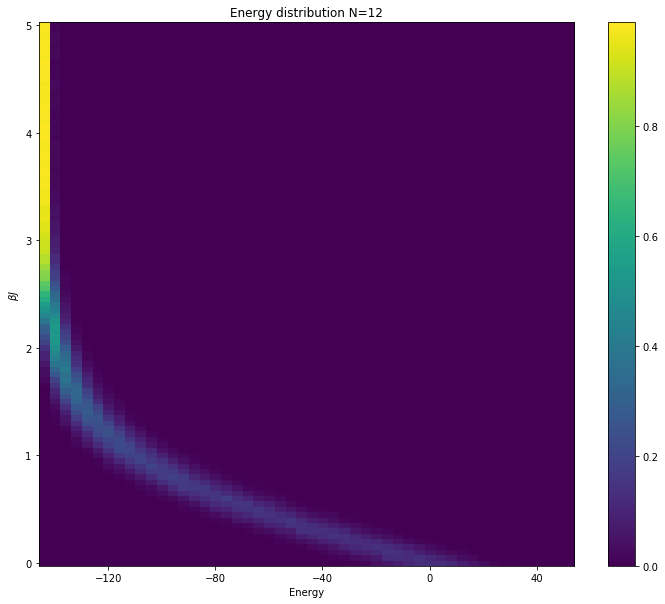

In [9]:
# Plot energy distribution of a single training dataset
fig, ax = plt.subplots(nrows=1, figsize=(12,10))
delta_beta = beta_list[1] - beta_list[0]
p = ax.imshow(E_distribution[0], 
              extent=[E_min - delta_E / 2,E_max + delta_E / 2,
                      beta_list[0] - delta_beta / 2,beta_list[-1] + delta_beta / 2],
              aspect='auto',
              origin='lower')
ax.set_xlabel("Energy")
ax.set_ylabel("$ \\beta J $")
ax.set_title("Energy distribution N=%d"%N)
plt.colorbar(p,ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[4])) # Increment ticks in step of 4 if possible

### Compute predictions from training data for test data

In [10]:
predicted_beta_test = np.zeros((n_splits,E_test.shape[0],E_test.shape[1]))
predicted_beta_test_mean = np.zeros((n_splits,beta_list.shape[0]))
divergence = np.zeros((n_splits, beta_list.shape[0]-2))  
beta_from_energy = np.zeros((n_splits, E_list.shape[0]))

def interpolation_factor(i,n):
    product=1
    for k in range(1,n+1):
        if k !=i:
            product *= k/(k-i)
    return product
n=0
interpolation_factors = [interpolation_factor(l,n) for l in range(1,n+1)]

for i in range(n_splits):
    E_train = E_data[:,i * n_configs_per_split : i * n_configs_per_split + n_train]
    E_test = E_data[:,i * n_configs_per_split + n_train : i * n_configs_per_split + n_train + n_test]

    is_energy_in_training_set = np.sum(E_distribution[i],axis=0) != 0
    
    # compute lookup table for average beta of the configuration with a given energy using 
    # the energy distribution of the training dataset
    
    interpolated_indexes = []
    for e in range(E_list.shape[0]):
        if is_energy_in_training_set[e]:
            beta_from_energy[i,e] = np.average(beta_list,weights=E_distribution[i,:,e])
        
        # Make linear interpolation if energy not present in training set 
        # This happens only at high energies / high temperatures
        else:
            assert e >= 2
            interpolated_indexes.append(e)
            beta_from_energy[i,e] = max(2 * beta_from_energy[i,e-1] - beta_from_energy[i,e-2],0)
    print("dataset %d: interpolate at indexes %s of %d"%(i, str(interpolated_indexes),E_list.shape[0]-1))
    
    # based on lookup table predict most likely beta for each config in test set
    for e in range(E_list.shape[0]):
        predicted_beta_test[i][E_test == E_list[e]] = beta_from_energy[i,e]
    
    # compute average predicted beta for each beta
    predicted_beta_test_mean[i] = predicted_beta_test[i].mean(axis=1)
    # predicted_beta_train_mean[i] = predicted_beta_train[i].mean(axis=1)
    
    # compute divergence of average predicted beta by central difference scheme
    h = beta_list[1]-beta_list[0]
    for b in range(1,beta_list.shape[0]-1):
        divergence[i,b-1] = (predicted_beta_test_mean[i,b+1] - predicted_beta_test_mean[i,b-1]) / (2*h)

dataset 0: interpolate at indexes [47, 48, 49] of 49
dataset 1: interpolate at indexes [47, 48, 49] of 49
dataset 2: interpolate at indexes [48, 49] of 49
dataset 3: interpolate at indexes [46, 48, 49] of 49
dataset 4: interpolate at indexes [46, 47, 48, 49] of 49


### Plot predictions from training data for test data

Text(0.5,1,'Energy distribution based estimation')

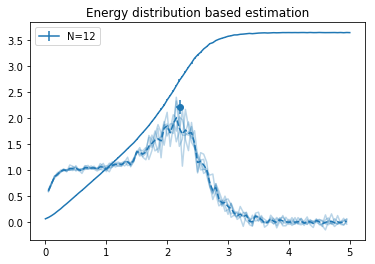

In [11]:
# Plot average predicted beta for each beta averaged over all datasets
# The error is based on variations over the 5 datasets 
# (Strong line with error bars)
p = plt.errorbar(beta_list, np.mean(predicted_beta_test_mean,axis=0),
                 np.std(predicted_beta_test_mean,axis=0), 
                 label="N=%d"%N)

# Plot average divergence
# (Dashed line)
plt.plot(beta_list[1:-1], np.mean(divergence,axis=0),'--',c=p[0].get_color())

# Plot divergence of each datset
# (faint lines)
for i in range(n_splits):
    plt.plot(beta_list[1:-1], divergence[i],alpha=0.3, 
             c=p[0].get_color()
            )
# get max_index of divergence for each dataset
i_max = np.argmax(divergence,axis=1)

# Plot maximum of divergence by averaging the maximum of divergence of each dataset
plt.errorbar([np.mean(beta_list[1:-1][i_max])],
             [np.mean(divergence[np.arange(n_splits),i_max])], 
             xerr=[np.std(beta_list[1:-1][i_max])], 
             yerr=[np.std(divergence[np.arange(n_splits),i_max])], 
             fmt='o', c=p[0].get_color())
plt.legend()
plt.title("Energy distribution based estimation")

# Neural Network based estimation

In [2]:
N = 12 # The configurations have NxN plaquettes and NxNx2 spins
beta_list = np.linspace(0,5,101) # Beta values used for the creation of the configurations
n_splits = 5 # The data is split in to n_splits datasets to estimate data dependant variations


### Model setup

In [3]:
#Setup the Keras Model 
inpt = Input((N,N,2))
x = Conv2D(128,(3,3),activation='relu',padding='same')(inpt) 
x = Conv2D(128,(3,3),activation='relu',padding='same')(x) 
x = Flatten()(x)
x = Dense(300,activation='relu')(x)
x = Dense(100,activation='relu')(x)
x = Dense(1)(x)

model = Model(inpt,x)
model.compile('adam','mse')

### Load data and labels

In [4]:
# Load generated configurations
data = np.load("Configs_N=%d.npy"%N) 
# data has shape (number_of_beta_values, number_of_configs, N, N, 2)

# The label of each configuration is the beta used at the generation
lables = np.zeros((data.shape[0], data.shape[1]))
for b,beta in enumerate(beta_list):
    lables[b] = [beta for _ in range(data.shape[1])]

In [5]:
# Split the data into 5 data sets each containing a training set and a test set
n_train = data.shape[1] // (2*n_splits)
n_test = data.shape[1] // (2*n_splits)
n_configs_per_split = n_train + n_test

# split the data and labels into 5 distinct training adn test sets
data_dict = {}
for i in range(n_splits):
    X_train = data[:,i * n_configs_per_split : i * n_configs_per_split + n_train].reshape(-1,N,N,2)
    Y_train = lables[:,i * n_configs_per_split : i * n_configs_per_split + n_train].reshape(-1)
    X_test = data[:,i * n_configs_per_split + n_train : 
                       i * n_configs_per_split + n_train + n_test].reshape(-1,N,N,2)
    Y_test =  lables[:,i * n_configs_per_split + n_train :
                       i * n_configs_per_split + n_train + n_test].reshape(-1)
    perm = np.arange(Y_train.shape[0])
    np.random.shuffle(perm)
    X_train = X_train[perm]
    Y_train=Y_train[perm]

    # Save test and training samples in data_dict
    data_dict[i] = {
        'X_train' : X_train,
        'Y_train' : Y_train,
        'X_test' : X_test,
        'Y_test' : Y_test,
    }

### Make predictions with pre-trained models

In [6]:
# For each dataset load parameters of model which was trained on the corresponding training set
# Evaluate for corresponding test set

# In fact, for each dataset multiple models were trained. 
# The best performing one on the training data one was selected for further evaluation.
# Here only the best performing model per dataset is loaded.

predicted_beta_test_mean = np.zeros((n_splits, beta_list.shape[0] ))
divergence = np.zeros((n_splits, beta_list.shape[0] -2))

for i in range(n_splits):
    print("i = %d"%i)
    
    save_path = "NN_models/beta_prediction_model_N=%d_trainingdata_%d_of_%d.h5"%(N,i,n_splits-1)     
    model.load_weights(save_path)
    
    prediction = model.predict(data_dict[i]['X_test'])
    
    # Compute average prediction for each beta label
    for b, beta in enumerate(beta_list):
        predicted_beta_test_mean[i,b] = np.mean(prediction[data_dict[i]['Y_test'] == beta])
    
    # Compute derivative of average prediction using central difference scheme
    h = beta_list[1]-beta_list[0]
    for j in range(1,beta_list.shape[0]-1):
        divergence[i,j-1] = (predicted_beta_test_mean[i,j+1] - predicted_beta_test_mean[i,j-1])/ (2*h)


i = 0
i = 1
i = 2
i = 3
i = 4


Text(0.5,1,'NN based estimation')

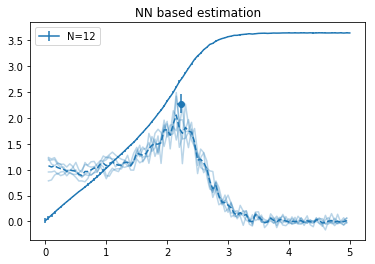

In [7]:
# Plot average predicted beta for each beta averaged over all datasets
# The error is based on variations over the 5 datasets 
# (Strong line with error bars)
p = plt.errorbar(beta_list, np.mean(predicted_beta_test_mean,axis=0),
                 np.std(predicted_beta_test_mean,axis=0), 
                 label="N=%d"%N)

# Plot average divergence
# (Dashed line)
plt.plot(beta_list[1:-1], np.mean(divergence,axis=0),'--',c=p[0].get_color())

# Plot divergence of each datset
# (faint lines)
for i in range(n_splits):
    plt.plot(beta_list[1:-1], divergence[i],alpha=0.3, 
             c=p[0].get_color()
            )
# get max_index of divergence for each dataset
i_max = np.argmax(divergence,axis=1)

# Plot maximum of divergence by averaging the maximum of divergence of each dataset
plt.errorbar([np.mean(beta_list[1:-1][i_max])],
             [np.mean(divergence[np.arange(n_splits),i_max])], 
             xerr=[np.std(beta_list[1:-1][i_max])], 
             yerr=[np.std(divergence[np.arange(n_splits),i_max])], 
             fmt='o', c=p[0].get_color())
plt.legend()
plt.title("NN based estimation")